In [31]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from typing import Tuple, Optional

In [4]:
def get_studio_bpm(beat_frames: np.ndarray, sr: int = 22050, hop_length: int = 512,
                   variance_threshold: float = 0.01, window_length: int = 4) -> Tuple[Optional[float], Optional[float], Optional[float], np.ndarray, np.ndarray]:
    """
    Analyze the provided beat frame indices to determine the studio BPM and the start frame of stable intervals.
    
    Parameters:
    - beat_frames (np.ndarray): Array of beat frame indices generated from librosa.
    - sr (int): The sample rate of the audio. Default is 22050 Hz.
    - hop_length (int): The number of samples per frame. Default is 512.
    - variance_threshold (float): The threshold for the variance to consider a window of beats as stable.
    - window_length (int): The number of beats to consider within each sliding window when calculating variance.

    Returns:
    Tuple[Optional[float], Optional[float], Optional[float], np.ndarray, np.ndarray]:
        - The mean studio BPM (float or None if not determined).
        - The median studio BPM (float or None if determined).
        - The BPM that occurs most frequently near a whole number (float or None if not determined).
        - The frame indices of the first beat of each stable interval.
        - An array of beat interval durations that are considered stable.
    """
    
    # Calculate the time in seconds for each beat frame index
    beat_times = librosa.frames_to_time(beat_frames, sr=sr, hop_length=hop_length)

    # Calculate beat intervals
    beat_intervals = np.diff(beat_times)
    total_intervals = len(beat_intervals)

    # Store stable intervals (low-variance windows)
    stable_intervals = []
    stable_frames = []

    # Calculate variance in a sliding window
    for i in range(total_intervals - window_length + 1):
        window = beat_intervals[i:i + window_length]
        if np.var(window) < variance_threshold:
            # Extend the list with intervals from the current stable window
            stable_intervals.extend(window)
            # Record the frame index of the first beat in the stable window
            stable_frames.append(beat_frames[i])


    # If we found any stable intervals, calculate the BPMs
    if stable_intervals:
        # Calculate BPMs for each stable interval
        stable_bpms = 60.0 / np.array(stable_intervals)
        mean_studio_bpm = np.mean(stable_bpms)
        median_studio_bpm = np.median(stable_bpms)
    
        # Find the BPM closest to a whole number
        differences = np.abs(stable_bpms - np.round(stable_bpms))
        index_of_closest_bpm = np.argmin(differences)
        closest_whole_bpm = stable_bpms[index_of_closest_bpm]
    else:
        # No stable intervals found; return None for mean and median BPM
        mean_studio_bpm = None
        median_studio_bpm = None
        closest_whole_bpm = None

    # Return the mean and median studio BPM if calculated, the mode BPM, the frame indices of the stable beats, and the stable interval durations
    return mean_studio_bpm, stable_frames


def quantize_beats(stable_frames: np.ndarray, studio_bpm: float, duration: float, sr: int = 22050, hop_length: int = 512):
    """
    Creates a measure grid based on the studio BPM and the starting time of the first stable interval, 
    extrapolating the grid to the start and end of the song.

    Parameters:
    stable_frames : np.ndarray
        An array of starting frames for stable beat interval sequences.
    studio_bpm : float
        Estimated studio BPM of the audio in beats per minute.
    sr : int
        Sampling rate of the audio signal.
    hop_length : int
        Hop length used in the onset detection and beat tracking.
    duration : float
        Duration of the audio signal in seconds.

    Returns:
    measure_grid : np.ndarray
        Array of quantized measure start times based on the BPM.
    measure_length : float
        Length of a measure in seconds based on the studio BPM.
    """ 
    # Hardcoded assumption of 4/4 time signature
    beats_per_measure = 4

    # Calculate beat interval in seconds using the studio BPM
    beat_interval = 60.0 / studio_bpm

    # Convert the frame index of the first stable interval to time
    first_stable_beat_time = librosa.frames_to_time(stable_frames[0], sr=sr, hop_length=hop_length)

    # Calculate the number of full measures from the start to first stable beat
    measures_to_first_stable = int(np.floor(first_stable_beat_time / (beat_interval * beats_per_measure)))

    # Calculate the start time of the first measure by subtracting the time of complete measures
    first_measure_time = first_stable_beat_time - (measures_to_first_stable * beat_interval * beats_per_measure)

    # Create the beat grid starting from the first measure time, going backwards to the beginning of the song
    backward_beat_grid = np.arange(first_measure_time, -beat_interval, -beat_interval)[::-1]
    
    # Create the beat grid starting from the first measure time, going forwards to the end of the song
    forward_beat_grid = np.arange(first_measure_time, duration, beat_interval)

    # Combine both grids and sort them to create a continuous beat grid
    beat_grid = np.sort(np.concatenate((backward_beat_grid, forward_beat_grid)))

    # Filter out any negative times that may have resulted from the backward extrapolation
    beat_grid = beat_grid[beat_grid >= 0]

    # Ensure beat grid does not go past the duration of the song
    beat_grid = beat_grid[beat_grid <= duration]

    # Create measure grid by selecting every fourth beat (assuming 4/4 time)
    measure_grid = beat_grid[::beats_per_measure]

    # Calculate the length of a measure
    measure_length = beat_interval * beats_per_measure

    return measure_grid, measure_length


def apply_measure_grid(ax, measure_grid):
    """
    This function takes an axis object and applies measure grid lines,
    sets x-ticks to measure start times for every fourth measure starting from measure 0,
    labels them with measure numbers, and applies sub-ticks for intermediate measure times.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis object to modify.
    measure_grid (list or array): The list or array of measure start times in seconds.
    """
    measure_numbers = np.arange(len(measure_grid))
    # Adjust the list to start from measure 0 and get every fourth measure
    major_measure_indices = [i for i, measure_num in enumerate(measure_numbers) if (measure_num) % 4 == 0]
    major_measures = [measure_grid[i] for i in major_measure_indices]
    major_labels = [measure_numbers[i] for i in major_measure_indices]
    
    # Set major x-axis ticks and labels (for measure 0 and every fourth measure after)
    ax.set_xticks(major_measures, minor=False)
    ax.set_xticklabels(major_labels, minor=False)

    # Set minor x-axis ticks (for intermediate measures)
    minor_measures = [measure for i, measure in enumerate(measure_grid) if i not in major_measure_indices]
    ax.set_xticks(minor_measures, minor=True)
    
    # Overlay the major measure grid lines on the plot (for measure 0 and every fourth measure after)
    for measure_time in major_measures:
        ax.axvline(x=measure_time, color='green', linestyle='--', linewidth=2)  # Adjusted linewidth for major ticks
    
    # Overlay the minor measure grid lines on the plot (for intermediate measures)
    for measure_time in minor_measures:
        ax.axvline(x=measure_time, color='grey', linestyle=':', linewidth=1, alpha=0.8)  # Adjusted linewidth for minor ticks
    
    ax.set_xlabel('Measure Number')

In [21]:
df = pd.read_csv(r'../data/dataframes/clean_labeled.csv')
data = df.loc[df["SongID"] == 2]
print(data)

   SongID  start_time    end_time   label                    TrackName  \
5       2         0.0   92.200000   other  Fly Kicks - Wax Motif Remix   
6       2        92.2  138.300000  chorus  Fly Kicks - Wax Motif Remix   
7       2       138.3  184.300000   other  Fly Kicks - Wax Motif Remix   
8       2       184.3  230.400000  chorus  Fly Kicks - Wax Motif Remix   
9       2       230.4  276.425034   other  Fly Kicks - Wax Motif Remix   

                               Artists       Genre  \
5  AC Slater, Chris Lorenzo, Wax Motif  Bass House   
6  AC Slater, Chris Lorenzo, Wax Motif  Bass House   
7  AC Slater, Chris Lorenzo, Wax Motif  Bass House   
8  AC Slater, Chris Lorenzo, Wax Motif  Bass House   
9  AC Slater, Chris Lorenzo, Wax Motif  Bass House   

                              FilePath  sp_danceability  sp_energy  sp_key  \
5  ..\data\audio_files\processed\2.mp3            0.897      0.692    11.0   
6  ..\data\audio_files\processed\2.mp3            0.897      0.692    11.0

In [26]:
data[["SongID","start_time", "end_time", "label"]]

,SongID,start_time,end_time,label
5,2,0.0,92.200000,other
6,2,92.2,138.300000,chorus
7,2,138.3,184.300000,other
8,2,184.3,230.400000,chorus
9,2,230.4,276.425034,other


In [22]:
# Load the audio file
audio_file = r"..\data\audio_files\processed\2.mp3"
hop_length = 512
sr = 22050

y, sr = librosa.load(audio_file, sr=sr) 
duration = librosa.get_duration(y=y, sr=sr, hop_length=hop_length)
y_harm, y_perc = librosa.effects.hpss(y)
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
studio_bpm, stable_frames = get_studio_bpm(beats)
# using spotify's tempo to create measure grid
tempo = data['sp_tempo'].iloc[0]
measure_grid, measure_length = quantize_beats(stable_frames, tempo, duration)

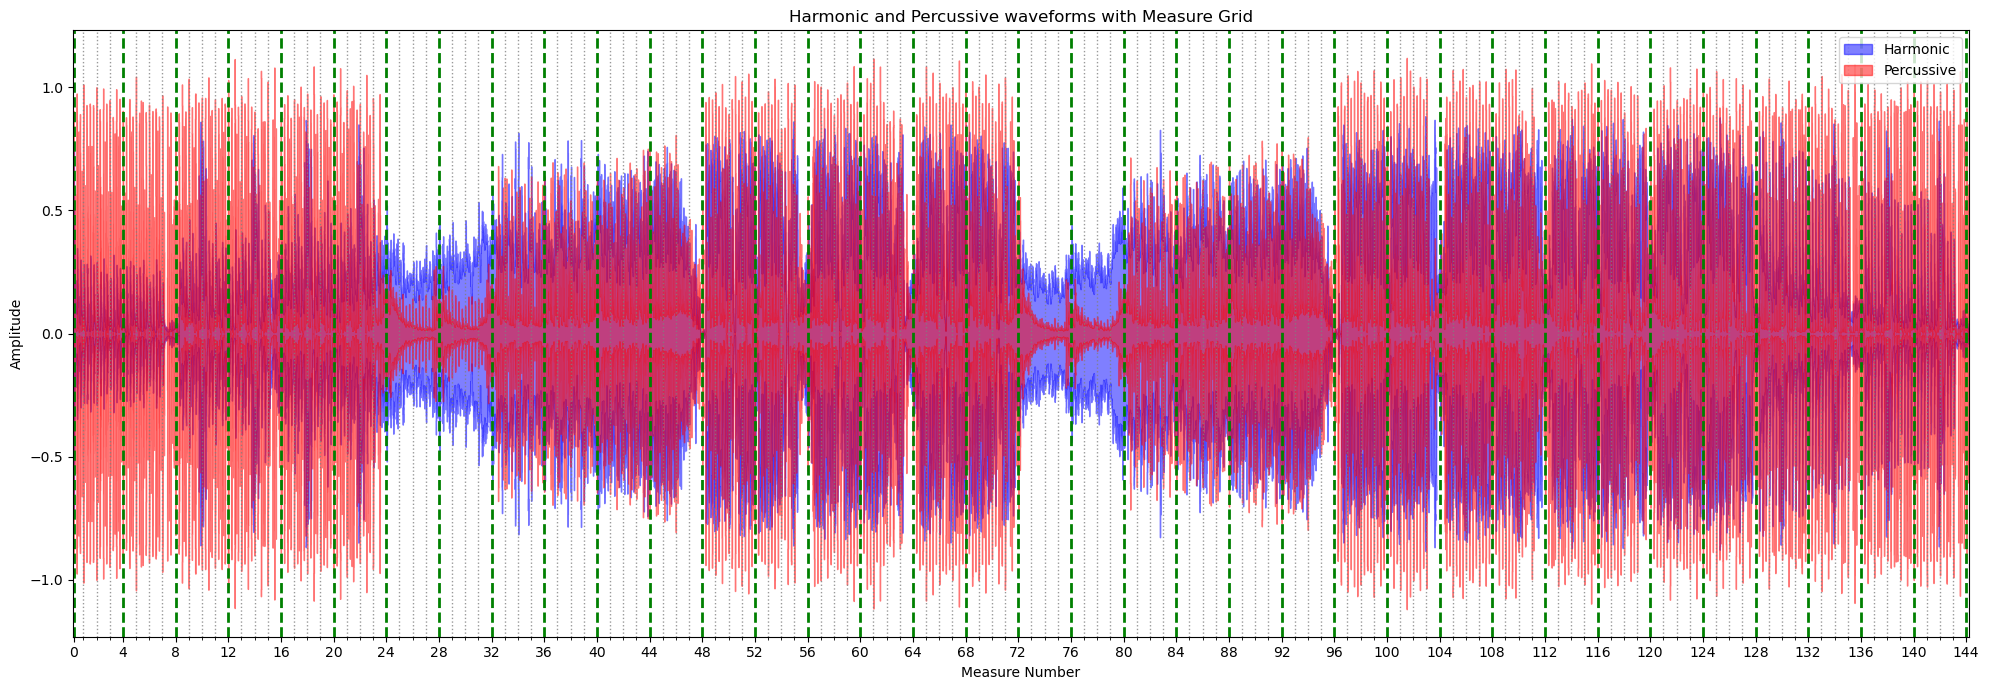

In [23]:
fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax, label='Harmonic', color='b')
librosa.display.waveshow(y_perc, sr=sr, alpha=0.5, ax=ax, label='Percussive', color='r')
ax.set_xlim([0, duration])
apply_measure_grid(ax, measure_grid)
ax.set_ylabel('Amplitude')
ax.set(title='Harmonic and Percussive waveforms with Measure Grid')
ax.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'MelSpectrogram')

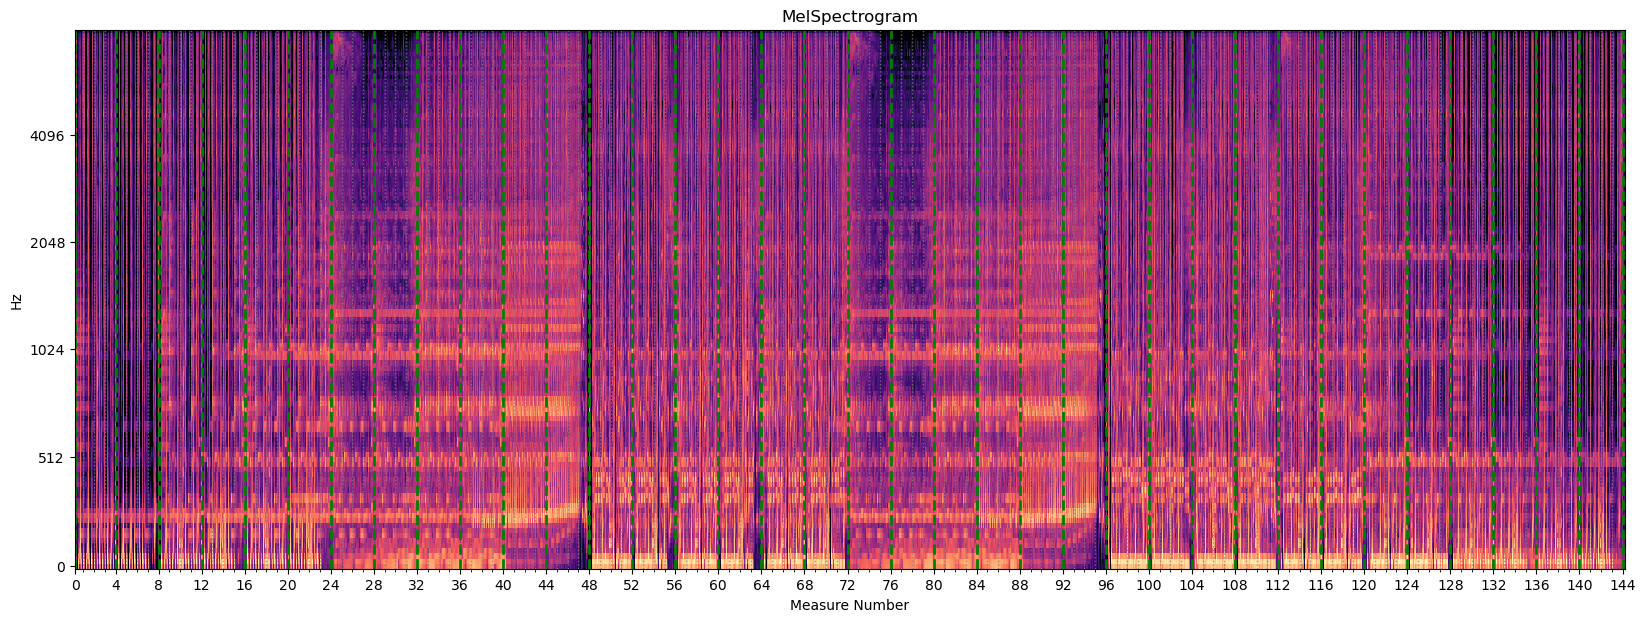

In [24]:
# Compute Melspectrogram
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
apply_measure_grid(ax, measure_grid)
ax.set_title('MelSpectrogram')

# Preprocessing data for CNN

In [30]:
# Parameters for the melspectrogram
audio_file = r"..\data\audio_files\processed\2.mp3"
sr = 22050
n_fft = 2048  # The number of data points used in each block for the FFT
hop_length = 512  # The number of samples between successive frames
n_mels = 128  # The number of bands in the mel scale

# Load audio file
audio, sr = librosa.load(audio_file, sr=sr)

# Initialize list for storing melspectrograms
melspectrograms = []

# Make sure measure_grid is sorted and convert to samples
measure_grid_samples = librosa.time_to_samples(measure_grid, sr=sr)

# Append the total number of samples in the audio to handle the last measure
measure_grid_samples = np.append(measure_grid_samples, len(audio))

for i in range(len(measure_grid_samples) - 1):
    start_sample = measure_grid_samples[i]
    end_sample = measure_grid_samples[i + 1]
    
    # Extract the measure as an audio segment
    measure = audio[start_sample:end_sample]
    
    # Compute the melspectrogram for the measure
    melspectrogram = librosa.feature.melspectrogram(y=measure, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert to decibel scale
    melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)
    
    # Normalize the melspectrogram
    melspectrogram_norm = librosa.util.normalize(melspectrogram_db)
    
    # Padding or trimming to the desired shape
    if melspectrogram_norm.shape[1] < n_mels:
        # If the melspectrogram is too short in time, pad it
        melspectrogram_padded = np.pad(melspectrogram_norm, ((0, 0), (0, n_mels - melspectrogram_norm.shape[1])), mode='constant')
    else:
        # If the melspectrogram is too long in time, trim it
        melspectrogram_padded = melspectrogram_norm[:, :n_mels]
    
    # Add a channel dimension for CNN input
    melspectrogram_padded = melspectrogram_padded[..., np.newaxis]
    
    melspectrograms.append(melspectrogram_padded)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = (128, 128, 1)  # n_mels is 128 as set in the preprocessing

# Number of classes
num_classes = 10  # Change this to the actual number of classes you have

# Build the CNN
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional layer 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Dense layer 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Model summary
model.summary()
